<a href="https://colab.research.google.com/github/ajay47847/pcg_classification/blob/main/psdNormAbr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


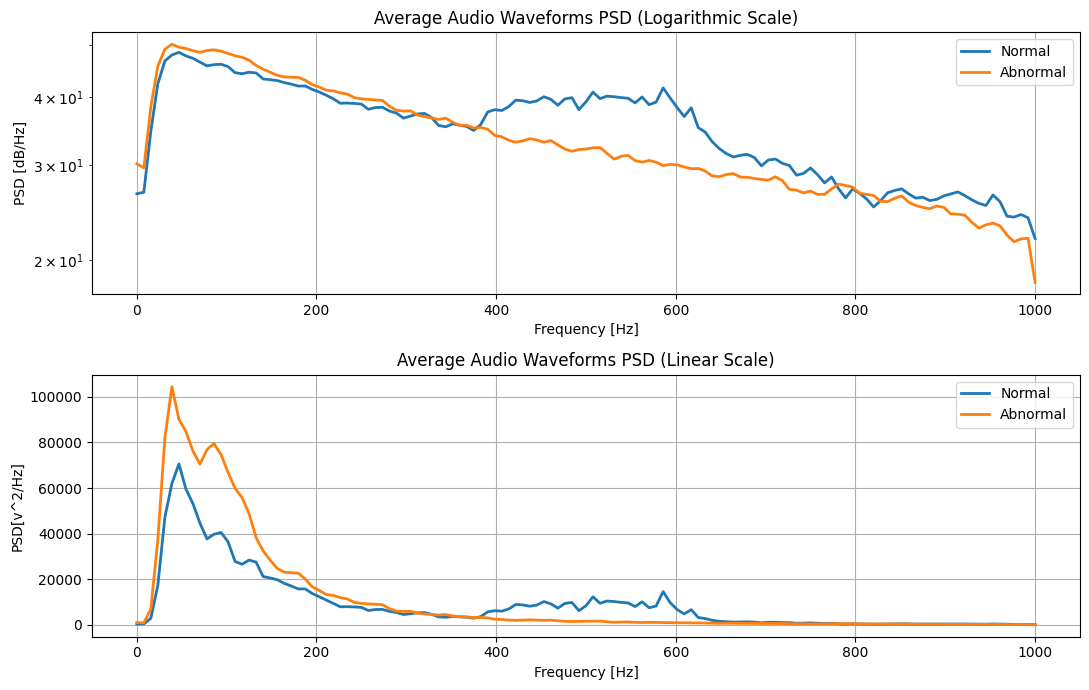

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.signal import welch

# Load the Excel file and select relevant columns
df = pd.read_excel('/content/PMEA_37_12_2181_OnlineAppendix.xlsx', sheet_name='SUAHSDB')
df = df[['Record name', 'Diagnosis', 'Type (-1=normal 1=abnormal)']]

# Extract 10 normal and 10 abnormal records
normal_records = df[df['Type (-1=normal 1=abnormal)'] == -1].head(10)
abnormal_records = df[df['Type (-1=normal 1=abnormal)'] == 1].head(10)

# Get the list of normal and abnormal record names
normal_record_names = normal_records['Record name'].tolist()
abnormal_record_names = abnormal_records['Record name'].tolist()

# Define the folder path containing the audio files
folder_path = '/content/drive/MyDrive/training-f'

# Get a list of all .wav files in the folder
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

# Filter the audio files based on normal and abnormal record names
normal_audio_files = [file for file in audio_files if any(record in file for record in normal_record_names)]
abnormal_audio_files = [file for file in audio_files if any(record in file for record in abnormal_record_names)]

# Function to load audio files and find minimum length
def load_audio_files(file_list):
    audio_data = []
    min_length = float('inf')
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        sr, y = wavfile.read(file_path)  # Load the audio file
        audio_data.append(y)
        min_length = min(min_length, len(y))
    # Trim all audio files to the minimum length
    audio_data = [audio[:min_length] for audio in audio_data]
    return np.array(audio_data), sr

# Load normal and abnormal audio data
normal_audio_data, sample_rate1 = load_audio_files(normal_audio_files)
abnormal_audio_data, sample_rate2 = load_audio_files(abnormal_audio_files)

# Extract 2.5 seconds of audio
duration = 2.5
num_samples1 = int(duration * sample_rate1)
num_samples2 = int(duration * sample_rate2)
normal_audio_data = normal_audio_data[:, :num_samples1]
abnormal_audio_data= abnormal_audio_data[:, :num_samples2]


def compute_psd(audio_data, sample_rate):
    psd_list = []
    for signal in audio_data:
        frequencies, psd = welch(signal, sample_rate)
        psd_list.append(psd)
    psd_array = np.array(psd_list)
    average_psd = np.mean(psd_array, axis=0)
    return frequencies, average_psd

frequencies, average_normal_audio_psd = compute_psd(normal_audio_data, sample_rate1)
frequencies, average_abnormal_audio_psd = compute_psd(abnormal_audio_data, sample_rate2)

# Convert PSD to dB
average_normal_audio_psd_db = 10 * np.log10(average_normal_audio_psd )
average_abnormal_audio_psd_db = 10 * np.log10(average_abnormal_audio_psd )

plt.figure(figsize=(11, 7))
# Plot PSD logarithmic scale
plt.subplot(2, 1, 1)
plt.plot(frequencies, average_normal_audio_psd_db, label='Normal', linewidth=2)
plt.plot(frequencies, average_abnormal_audio_psd_db, label='Abnormal', linewidth=2)
plt.yscale('log')
plt.title('Average Audio Waveforms PSD (Logarithmic Scale)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)
plt.legend()

# Plot PSD linear scale
plt.subplot(2, 1, 2)
plt.plot(frequencies, average_normal_audio_psd, label='Normal', linewidth=2)
plt.plot(frequencies, average_abnormal_audio_psd, label='Abnormal', linewidth=2)
plt.title('Average Audio Waveforms PSD (Linear Scale)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD[v^2/Hz]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
